In [20]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from autoencoder import full_network
from training import create_feed_dictionary, create_feed_dictionary2

from sindy_utils import *
from error_utils import *
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import seaborn as sns
import matplotlib.patches as patches
from copy import deepcopy
%matplotlib inline
import random
import subprocess as sp
from sklearn.linear_model import LinearRegression
import copy
import matplotlib.tri as tri
from matplotlib import cm

def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(10)

In [2]:
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

device_list = tf.config.list_physical_devices('GPU')
free_mem = get_gpu_memory()
for i,gpu in enumerate(device_list):
    print(f'{gpu}: free memory: {free_mem[i]}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'): free memory: 16149


In [3]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,visible_device_list='1'))

In [4]:
data_path = os.getcwd() + '/fig/nCase121b_tstop3_ld3_p1_1e-3_lr1e-3_width100_nDI25_upEP3e4_resNS0.1/'

# params_results = pickle.load(open(data_path + 'experiment_results_2021_08_28_13_40.pkl', 'rb'))
save_name = 'ex9_2022_02_06_20_13_22'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name
activation = params['activation']
lamb1 = params['loss_weight_sindy_x']
lamb2 = params['loss_weight_sindy_z']
lamb3 = params['loss_weight_sindy_regularization']
scaled = False
if scaled:
    scaler_x = params['scaler_x']
    scaler_dx = params['scaler_dx']
params['coeff_exist'] = False
params['config'] = config
params['diff'] = 'symb'

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

In [5]:
print(params['convex_knn'], params['num_test'], params['tol2'], 
      params['update_epoch'], params['max_epochs'], params['subsize_max'])

1 121 5 30000 1708807 50


In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def silu(x):
    return x * sigmoid(x)

def NN(x, weights, biases, activation):
    """
    this networks serve as either an encoder or a decoder.
    """
    num_layers = len(weights)
    for i in range(num_layers-1):
        x = np.matmul(x, weights[i]) + biases[i]
        if activation == 'tanh':
            x = np.tanh(x)
        elif activation == 'sigmoid':
            x = sigmoid(x)
            
    # output layer (linear activation)
    x = np.matmul(x, weights[-1]) + biases[-1]
    return x

def derivative(x):
    dxdt = np.empty(x.shape)
    D = D_Lele(x.shape[0], tstop/x.shape[0])   
    for i in range(x.shape[1]):
        dxdt[:,i] = np.dot(D.toarray(), x[:,i])
    del D
    return dxdt

In [7]:
def eval_perf(test_data, params, test_param, idx=None, knn=4, calc_dz=False, calc_du=False):  
    timer = []
    
    # Step 1: set up tf graph and load parameters, can be optimized, excluded from ROM computational time
    timer.append(time()) 
    include_sine = False
    include_cosine = False
    if 'include_sine' in params.keys():
        include_sine = params['include_sine']
    if 'include_cosine' in params.keys():
        include_cosine = params['include_cosine']
        
#     sind_coeff_all = params['model_params'][0] # coefficients of all local SINDys
    z_encoder = NN(test_data['x'], params['model_params'][1], params['model_params'][2], activation) # encoder
    u_decoder = NN(z_encoder, params['model_params'][3], params['model_params'][4], activation) # decoder
    
    
    # Step 2: find the nearest neighbor (optional)
    timer.append(time()) 
    if idx == None:
        train_param = np.stack(params['param'])
        idx = np.argmin(np.linalg.norm(train_param-test_param, axis=1))
    
    
    # Step 3: calculate SINDy coefficients
    timer.append(time())        
    if knn == 1:
        print(f"Index of the nearest local SINDy: {idx+1}")
        sindy_coeff = params['model_params'][0][idx]
        
    else: # KNN convex interpolation of coefficients
        dist = np.linalg.norm(train_param-test_param, axis=1)
        knn_idx = np.argsort(dist)[:knn]
        phi = np.zeros_like(knn_idx)
        if dist[knn_idx[0]] == 0: # check if the min distance is zero
            phi[0] = 1
        else:
            phi = 1 / np.linalg.norm(train_param[knn_idx]-test_param, axis=1)**2
        psi = phi / phi.sum()
#         print("Weighted Convex interpolation of local SINDys: ", psi)

        sindy_coeff = np.zeros(params['model_params'][0][0].shape)
        for i,kidx in enumerate(knn_idx):
            sindy_coeff += psi[i] * params['model_params'][0][kidx]
            

    # Step 4: lastent-space dynamics prediction and obtain physical dynamics
    timer.append(time())
    z_sim = sindy_simulate(z_encoder[0,:], test_data['t'].squeeze(), 
                           sindy_coeff, params['poly_order'], 
                           include_sine,include_cosine)
    u_sim = NN(z_sim, params['model_params'][3], params['model_params'][4], activation)

    timer.append(time())
    
    if calc_dz:
        dz_encoder = derivative(z_encoder)
        dz_sim = derivative(z_sim)
    else:
        dz_encoder = 0
        dz_sim = 0
        
    if calc_du:
        du_decoder = derivative(u_decoder)
        du_sim = derivative(u_sim)
    else:
        du_decoder = 0
        du_sim = 0
        
#     du_sindy = test_set_results['dx_decode'][:,idx,:]
#     dz_encoder = test_set_results['dz'][:,idx,:]
#     dz_sindy = test_set_results['dz_predict'][:,idx,:]
    
    
    timer1 = np.array(timer)
    timer2 = timer1[1:]
    timer_rom = timer2 - timer1[:-1]

    return u_decoder, du_decoder, u_sim, du_sim, z_encoder, dz_encoder, z_sim, dz_sim, idx, timer_rom

In [8]:
def plot_field(data, pred, step=-1, pred_label='SINDy-Decoder'):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(131)
    ax.set_title('Data', fontsize=16)
    im = ax.imshow(data[step, :, :], vmin=0.0, vmax=1.0)
    ax.axis('off')
#     plt.colorbar()

    ax = fig.add_subplot(132)
    ax.set_title(pred_label, fontsize=16)
    ax.imshow(pred[step, :, :], vmin=0.0, vmax=1.0)
    ax.axis('off')
#     plt.colorbar()

    ax = fig.add_subplot(133)
    ax.set_title('Error', fontsize=16)
    ax.imshow(np.abs(data[-1, :, :]-pred[-1, :, :]), vmin=0.0, vmax=1.0)
    ax.axis('off')
#     plt.imshow(np.abs(data[idx, step, :, :]-pred[idx, step, :, :]), vmin=0.0)

    plt.tight_layout()
    cbar_ax = fig.add_axes([1.01, 0.25, 0.015, 0.5])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.ax.tick_params(labelsize=16)
    plt.show()

### Interpolative prediction

In [9]:
knn = 1
w1 = 1.5
w2 = 2
tstop = 3
t_test = tstop
test_data = pickle.load(open(f"./data/local1_p1{w1:.1f}_p2{w2:.1f}_tstop{tstop:.1f}.p", "rb"))
nt = test_data['data'][0]['x'].shape[0]
t = np.linspace(0,t_test,nt)

# discretization coordinates
vert = np.loadtxt('./data/vertex.txt')
triang = tri.Triangulation(vert[:,0], vert[:,1])

test_data_x = test_data['data'][0]['x']
test_data_dx = test_data['data'][0]['dx']

In [10]:
u_decoder,du_decoder,u_sim,du_sim,z_encoder,dz_encoder,z_sim,dz_sim,idx,timer_rom = eval_perf(test_data['data'][0], params,
                                                                                               test_data['param'][0], knn=knn,
                                                                                               calc_dz=True, calc_du=True)
u_decoder = u_decoder.squeeze()
print(z_sim.shape, u_sim.shape, u_decoder.shape)

Index of the nearest local SINDy: 1
(301, 3) (301, 9216) (301, 9216)


In [11]:
# Max relative error of all time steps
err_decoder = np.linalg.norm(test_data_x - u_decoder, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
err_sindy = np.linalg.norm(test_data_x - u_sim, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
print(f'max autoencoder error: {err_decoder.max():.2f} %')
print(f'max sindy-decoder error: {err_sindy.max():.2f} %')

max autoencoder error: 0.94 %
max sindy-decoder error: 1.05 %


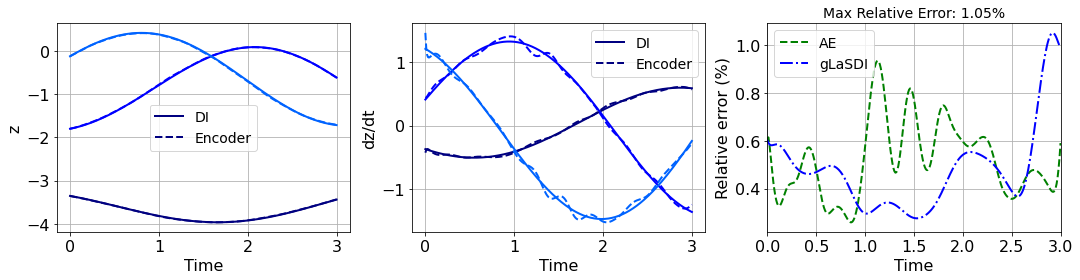

In [12]:
fig1 = plt.figure(figsize=(15,4))
ax = fig1.add_subplot(131)
for i in range(z_sim.shape[1]):
    ax.plot(t, z_sim[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t, z_encoder[:,i], '--', linewidth=2, c=cmap(i))
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('z', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend(['DI', 'Encoder'],fontsize=14)
ax.grid()
# ax.set_title('DI predicted latent dynamics', fontsize=14)

ax = fig1.add_subplot(132)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_sim[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t, dz_encoder[:,i], '--', linewidth=2, c=cmap(i))
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('dz/dt', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend(['DI', 'Encoder'],fontsize=14)
ax.grid()
# ax.set_title('DI predicted latent dynamics', fontsize=14)

ax = fig1.add_subplot(133)
ax.plot(t, err_decoder, 'g--', linewidth=2, label='AE')
ax.plot(t, err_sindy, 'b-.', linewidth=2, label='gLaSDI')
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Relative error (%)', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.grid()
ax.set_xlim(0,t_test)
ax.set_title(f'Max Relative Error: {err_sindy.max():.2f}%', fontsize=14)
ax.legend(fontsize=14, loc='upper left')

plt.tight_layout()
plt.savefig(data_path + f"latent_dynamics.png")

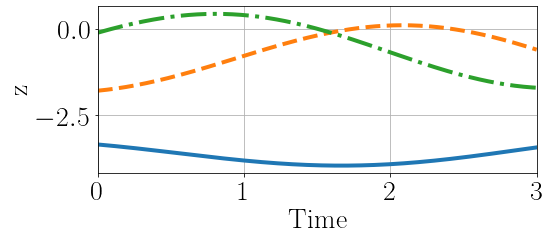

In [13]:
plt.rcParams.update({"font.size": 28,
                     "text.usetex": True,
                     "font.family": "Times New Roman"}) # fontsize for figures

fig1 = plt.figure(figsize=(8,4))
ax = fig1.add_subplot(111)
line_type = ['-','--','-.']
for i in range(z_sim.shape[1]):
    ax.plot(t, z_sim[:,i], line_type[i], linewidth=4)
ax.set_xlabel('Time')
ax.set_ylabel('z',fontsize=28)
ax.set_xlim(0,t.max())
ax.tick_params(axis='both')
# ax.xaxis.set_ticks([])
# ax.yaxis.set_ticks([])
ax.grid()
plt.tight_layout()
plt.savefig(data_path + f"MFEM16_latent_dynamics.png",bbox_inches='tight')

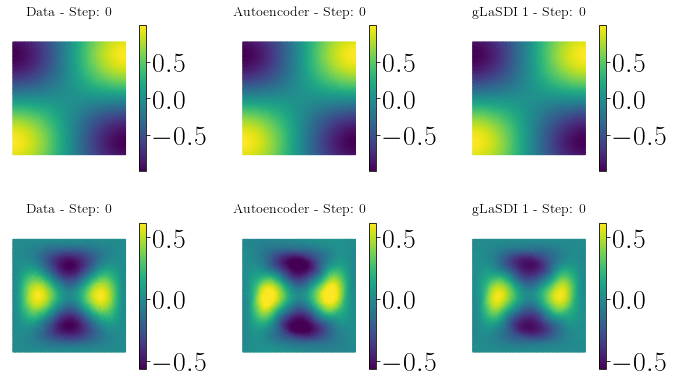

In [14]:
step = int(nt/1)-1
step = 0
vmin_x = test_data_x[step,:].min()
vmax_x = test_data_x[step,:].max()
vmin_dx = test_data_dx[step,:].min()
vmax_dx = test_data_dx[step,:].max()

fig1 = plt.figure(figsize=(10,6))
ax = fig1.add_subplot(231)
# p_u = ax.tripcolor(triang, test_data_x[step], shading='gouraud')
p_u = ax.tripcolor(triang, test_data_x[step], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'Data - Step: {step}', fontsize=14, pad=20)
ax.set_aspect('equal')
plt.axis('off')
    
ax = fig1.add_subplot(232)
# p_u = ax.tripcolor(triang, u_decoder[step], shading='gouraud')
p_u = ax.tripcolor(triang, u_decoder[step], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'Autoencoder - Step: {step}', fontsize=14, pad=20)
ax.set_aspect('equal')
plt.axis('off')
    
ax = fig1.add_subplot(233)
# p_u = ax.tripcolor(triang, u_sim[step], shading='gouraud')
p_u = ax.tripcolor(triang, u_sim[step], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'gLaSDI {idx+1} - Step: {step}', fontsize=14, pad=20)
ax.set_aspect('equal')
plt.axis('off')

ax = fig1.add_subplot(234)
# p_u = ax.tripcolor(triang, test_data_x[step], shading='gouraud')
p_u = ax.tripcolor(triang, test_data_dx[step], shading='gouraud', vmin=vmin_dx, vmax=vmax_dx)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'Data - Step: {step}', fontsize=14, pad=20)
ax.set_aspect('equal')
plt.axis('off')
    
ax = fig1.add_subplot(235)
# p_u = ax.tripcolor(triang, u_decoder[step], shading='gouraud')
p_u = ax.tripcolor(triang, du_decoder[step], shading='gouraud', vmin=vmin_dx, vmax=vmax_dx)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'Autoencoder - Step: {step}', fontsize=14, pad=20)
ax.set_aspect('equal')
plt.axis('off')
    
ax = fig1.add_subplot(236)
# p_u = ax.tripcolor(triang, u_sim[step], shading='gouraud')
p_u = ax.tripcolor(triang, du_sim[step], shading='gouraud', vmin=vmin_dx, vmax=vmax_dx)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'gLaSDI {idx+1} - Step: {step}', fontsize=14, pad=20)
ax.set_aspect('equal')
plt.axis('off')

plt.tight_layout()
plt.savefig(data_path + f"inter_pred.png")

In [15]:
# step = int(nt/1)-1
# step = 0
# vmin_dx = test_data_dx.min()
# vmax_dx = test_data_dx[:].max()

# fig1 = plt.figure(figsize=(18,4))
# ax = fig1.add_subplot(141)
# p_u = ax.tripcolor(triang, test_data_dx[step], shading='gouraud', vmin=vmin_dx, vmax=vmax_dx)
# cb_u = fig1.colorbar(p_u, ax=ax)
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel('y', fontsize=16)
# ax.tick_params(axis='both', labelsize=16)
# ax.set_title(f'Data - Step: {step}', fontsize=16)

# ax = fig1.add_subplot(143)
# p_u = ax.tripcolor(triang, du_sim[step], shading='gouraud', vmin=vmin_dx, vmax=vmax_dx)
# cb_u = fig1.colorbar(p_u, ax=ax)
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel('y', fontsize=16)
# ax.tick_params(axis='both', labelsize=16)
# ax.set_title(f'Autoencoder - Step: {step}', fontsize=16)

# ax = fig1.add_subplot(142, projection='3d')
# p_u = ax.plot_trisurf(vert[:,0], vert[:,1], test_data_dx[step], cmap=cm.viridis, vmin=vmin_dx, vmax=vmax_dx)
# ax.view_init(elev=30,azim=60)
# cb_u = fig1.colorbar(p_u,ax=ax)
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel('y', fontsize=16)
# ax.tick_params(axis='both', labelsize=16)
# ax.tick_params(axis='z', labelsize=16, pad=10)
# ax.set_title(f'Data - Step: {step}', fontsize=16)

# ax = fig1.add_subplot(144, projection='3d')
# p_u = ax.plot_trisurf(vert[:,0], vert[:,1], du_sim[step], cmap=cm.viridis, vmin=vmin_dx, vmax=vmax_dx)
# ax.view_init(elev=30,azim=60)
# cb_u = fig1.colorbar(p_u,ax=ax)
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel('y', fontsize=16)
# ax.tick_params(axis='both', labelsize=16)
# ax.tick_params(axis='z', labelsize=16, pad=10)
# ax.set_title(f'Autoencoder - Step: {step}', fontsize=16)

# plt.tight_layout()

In [ ]:
nstep = 10
step_list = np.linspace(0,nt-1,nstep).astype(int)
vmin_x = test_data_x.min()
vmax_x = test_data_x.max()
vmin_dx = test_data_dx.min()/10
vmax_dx = test_data_dx.max()/10

fig = plt.figure(figsize=(18,8))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(4,nstep,i+1)
#     ax.tripcolor(triang, test_data_x[step], shading='gouraud')
    ax.tripcolor(triang, test_data_x[step], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
    ax.set_title(f'u - step: {step}')
    ax.set_aspect('equal')
    plt.axis('off')
# plt.colorbar()
# plt.clim(test_data_x.min(), test_data_x.max())
plt.tight_layout()

for i,step in enumerate(step_list):
    ax = fig.add_subplot(4,nstep,i+1+nstep)
#     ax.tripcolor(triang, u_sim[step], shading='gouraud')
    ax.tripcolor(triang, u_sim[step], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
    ax.set_title(f'$u_{pred} - step: {step}$')
    ax.set_aspect('equal')
    plt.axis('off')
# plt.colorbar()
# plt.clim(test_data_x.min(), test_data_x.max())
plt.tight_layout()
    
for i,step in enumerate(step_list):
    ax = fig.add_subplot(4,nstep,i+1+nstep*2)
#     ax.tripcolor(triang, test_data_dx[step], shading='gouraud')
    ax.tripcolor(triang, test_data_dx[step], shading='gouraud', vmin=vmin_dx, vmax=vmax_dx)
    ax.set_title(f'du - step: {step}')
    ax.set_aspect('equal')
    plt.axis('off')
# plt.colorbar()
# plt.clim(test_data_dx.min(), test_data_dx.max())
plt.tight_layout()
    
for i,step in enumerate(step_list):
    ax = fig.add_subplot(4,nstep,i+1+nstep*3)
#     ax.tripcolor(triang, du_sim[step], shading='gouraud')
    ax.tripcolor(triang, du_sim[step], shading='gouraud', vmin=vmin_dx, vmax=vmax_dx)
    ax.set_title(f'$du_{pred} - step: {step}$')
    ax.set_aspect('equal')
    plt.axis('off')
# plt.colorbar()
# plt.clim(test_data_dx.min(), test_data_dx.max())
plt.tight_layout()
plt.savefig(data_path + f"inter_pred_multisteps.png")

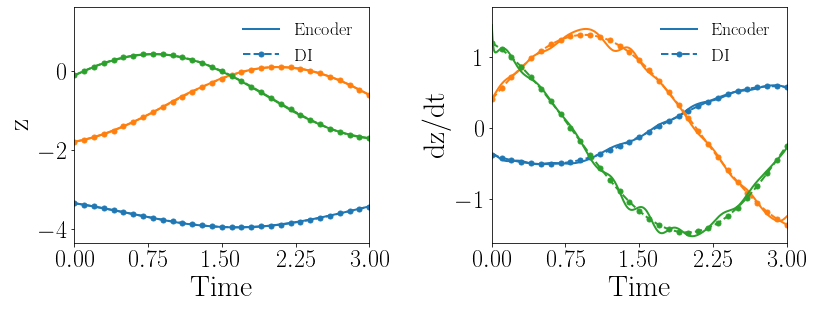

In [25]:
plt.rcParams.update({"font.size": 30,
                     "text.usetex": True,
                     "font.family": "Times New Roman"}) # fontsize for figures

fig1 = plt.figure(figsize=(12,5))
line_type = ['-','-*','-.','-^','-s']
idx = np.arange(0,t.size,10)
ax = fig1.add_subplot(121)
for i in range(z_encoder.shape[1]):
    ax.plot(t, z_encoder[:,i], '-', lw=2, c=cmap(i))
    ax.plot(t[idx], z_sim[idx,i], '--o', lw=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('z')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_ylim(z_sim.min()*1.1,z_sim.max()+1.2)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=18)
# ax.grid()
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(122)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_encoder[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t[idx], dz_sim[idx,i], '--o', linewidth=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('dz/dt')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_xlim(0,t.max())
ax.set_ylim(dz_sim.min()*1.1,dz_sim.max()*1.3)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=18)
# ax.grid()

plt.tight_layout()
plt.savefig(data_path + f"advection_latent_dynamics.png",bbox_inches='tight')

### Extended domain

In [40]:
knn = 4
res_nstep = nt
res_name = f'mean'
    

na = 21
nw = na
# amp_test = np.linspace(1.5, 2, na)
# width_test = np.linspace(2, 2.5, nw)

amp_test = np.linspace(1.5, 1.8, na)
width_test = np.linspace(2, 2.3, nw)

# amp_test = params['test_param'][:,0]
# width_test = params['test_param'][:,1]

# amp_test = np.array([0.3])
# width_test = np.array([0.25])

num_case = amp_test.size * width_test.size
max_err = np.zeros([len(amp_test), len(width_test)])
mse_map = np.zeros([len(amp_test), len(width_test)])
res_norm = np.zeros([len(amp_test), len(width_test)])
sindy_idx = np.zeros([len(amp_test), len(width_test)])
if num_case > 1:
#     test_data_all = pickle.load(open(f"./data/local{num_case}_tstop{tstop:.1f}.p", "rb"))
    test_data_all = pickle.load(open(f"./data/local{num_case}_tstop{tstop:.1f}b.p", "rb"))
else:
    test_data_all = pickle.load(open(f"./data/local1_p1{amp_test[0]:.1f}_p2{width_test[0]:.1f}_tstop{tstop:.1f}.p", "rb"))

speed_up = 0
count = 0
timer_rom = np.zeros(4)
start_time = time()
for i,a in enumerate(amp_test):
    for j,w in enumerate(width_test):
        print(f"{count}/{num_case}: {test_data_all['param'][count]}")
        test_data = {}
        test_data['data'] = [deepcopy(test_data_all['data'][count])]
        test_data['param'] = [deepcopy(test_data_all['param'][count])]
        
        _,_,u_sim,_,_,_,_,_,idx,t_rom = eval_perf(test_data['data'][0], params, 
                                              test_data['param'][0], knn=knn)
        timer_rom += t_rom
        sindy_idx[i,j] = idx+1
        
        # MSE of all time steps
        mse = np.linalg.norm(test_data['data'][0]['x'] - u_sim)**2
        mse_map[i,j] = mse
        
        # Max error of all time steps
        max_err[i,j] = (np.linalg.norm(test_data['data'][0]['x'] - u_sim, axis=1) \
                        / np.linalg.norm(test_data['data'][0]['x'], axis=1)*100).max()
        
        # residual norm
        res_norm[i,j] = err_indicator(u_sim, params, err_type=params['err_type'])
        count += 1

end_time = time()
time_rom = timer_rom[1:].sum()/num_case # from Step 2 to 4
time_sim = 3.8 # seconds
speed_up = time_sim / time_rom
print(f'Time taken: {end_time-start_time:.2f} s, {(end_time-start_time)/60:.2f} mins')
print(f'Max relative error: {max_err.max() :.2f} %')
print(f'Average MSE: {mse_map.sum() / num_case:.2f}')
print(f'Average speed up: {speed_up:.2f}')
# for i,t in enumerate(timer_rom):
#     print(f'ROM time{i}: {t:.8f} s')

0/441: [1.5 2. ]
1/441: [1.5   2.015]
2/441: [1.5  2.03]
3/441: [1.5   2.045]
4/441: [1.5  2.06]
5/441: [1.5   2.075]
6/441: [1.5  2.09]
7/441: [1.5   2.105]
8/441: [1.5  2.12]
9/441: [1.5   2.135]
10/441: [1.5  2.15]
11/441: [1.5   2.165]
12/441: [1.5  2.18]
13/441: [1.5   2.195]
14/441: [1.5  2.21]
15/441: [1.5   2.225]
16/441: [1.5  2.24]
17/441: [1.5   2.255]
18/441: [1.5  2.27]
19/441: [1.5   2.285]
20/441: [1.5 2.3]
21/441: [1.515 2.   ]
22/441: [1.515 2.015]
23/441: [1.515 2.03 ]
24/441: [1.515 2.045]
25/441: [1.515 2.06 ]
26/441: [1.515 2.075]
27/441: [1.515 2.09 ]
28/441: [1.515 2.105]
29/441: [1.515 2.12 ]
30/441: [1.515 2.135]
31/441: [1.515 2.15 ]
32/441: [1.515 2.165]
33/441: [1.515 2.18 ]
34/441: [1.515 2.195]
35/441: [1.515 2.21 ]
36/441: [1.515 2.225]
37/441: [1.515 2.24 ]
38/441: [1.515 2.255]
39/441: [1.515 2.27 ]
40/441: [1.515 2.285]
41/441: [1.515 2.3  ]
42/441: [1.53 2.  ]
43/441: [1.53  2.015]
44/441: [1.53 2.03]
45/441: [1.53  2.045]
46/441: [1.53 2.06]
47/441: 

In [41]:
a_grid, w_grid = np.meshgrid(amp_test, width_test)
param_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

a_grid, w_grid = np.meshgrid(np.arange(amp_test.size), np.arange(width_test.size))
idx_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

idx_param = []
for i,ip in enumerate(params['param']):
    idx = np.argmin(np.linalg.norm(param_list-ip, axis=1))
    idx_param.append((idx, np.array([param_list[idx,0], param_list[idx,1]])))

In [42]:
max_err_train = []
res_norm_train = []
for i in idx_param:
    idd = i[0]
    max_err_train.append(max_err[idx_list[idd,0],idx_list[idd,1]])
    res_norm_train.append(res_norm[idx_list[idd,0],idx_list[idd,1]])
max_err_train = np.stack(max_err_train)
res_norm_train = np.stack(res_norm_train)
err_ratio_train = res_norm_train / max_err_train
err_ratio_train_mean = err_ratio_train.mean()
res_norm_tol = err_ratio_train_mean * params['tol2']
print(f'tolerance of residual norm (mean): {res_norm_tol:.5f}')
print(f"tolerance of residual norm (reg_max): {params['tol']:.5f}")

tolerance of residual norm (mean): 0.09318
tolerance of residual norm (reg_max): 0.00911


In [43]:
# fig = plt.figure(figsize=(18,4))
# ax = fig.add_subplot(131)
# ax.plot(np.arange(1,res_norm.size+1), res_norm.flatten(), 'r.', label='res_norm_'+res_name)
# # ax.set_xlabel('Time Steps', fontsize=14)
# ax.set_ylabel('Errors', fontsize=14)
# ax.tick_params(labelsize=14)
# ax.grid()
# ax.legend(fontsize=14)

# ax = fig.add_subplot(132)
# ax.plot(np.arange(1,res_norm.size+1), max_err.flatten(), 'b.', label='maxRelErr')
# # ax.set_xlabel('Time Steps', fontsize=14)
# ax.set_ylabel('Errors', fontsize=14)
# ax.tick_params(labelsize=14)
# ax.grid()
# ax.legend(fontsize=14)

# ax = fig.add_subplot(133)
# x = max_err.flatten().reshape(-1,1)
# y = res_norm.flatten().reshape(-1,1)
# reg = LinearRegression().fit(x, y)
# y_pred = reg.predict(x)
# y_diff = y - y_pred
# x_test = np.linspace(0,max_err.max(),2).reshape(-1,1)
# y_test = reg.predict(x_test)
# y_test1 = reg.coef_ * x_test + reg.intercept_+ y_diff.min()
# y_test2 = reg.coef_ * x_test + reg.intercept_+ y_diff.max()
# y_test3 = reg.coef_ * params['tol2'] + reg.intercept_+ y_diff.max()
# ax.plot(max_err.flatten(), res_norm.flatten(), 'g.')
# ax.plot(x_test,y_test,'r-')
# ax.plot(x_test,y_test1,'r--')
# ax.plot(x_test,y_test2,'r--')

# x_test2 = np.linspace(0,params['tol2'],2).reshape(-1,1)
# y_test2 = err_ratio_train_mean * x_test2
# # ax.plot(x_test2,y_test2,'b-')
# # ax.plot([0,x_test2.max()],[res_norm_tol,res_norm_tol],'b--')
# # ax.plot([x_test2.max(),x_test2.max()],[0,max(y_test3,res_norm_tol)],'k--')
# # ax.plot(x_test2.max(),res_norm_tol,'b.',markersize=15, label='mean')
# # ax.plot(params['tol2'],y_test3,'r.',markersize=15, label='reg')
# plt.legend(fontsize=16)

# # y_test3 = 0.5*(err_ratio_train_mean+reg.coef_[0][0]) * x_test2 + reg.intercept_[0]
# # res_norm_tol2 = 0.5*(err_ratio_train_mean+reg.coef_[0][0]) * params['tol2'] + reg.intercept_[0]
# # y_test3 = 0.5*(err_ratio_train_mean+reg.coef_[0][0]) * x_test2
# # res_norm_tol2 = 0.5*(err_ratio_train_mean+reg.coef_[0][0]) * params['tol2']
# # ax.plot(x_test2,y_test3,'k-')
# # ax.plot([0,x_test2.max()],[res_norm_tol2,res_norm_tol2],'k--')
# # ax.plot([x_test2.max(),x_test2.max()],[0,res_norm_tol2],'k--')
# # ax.plot(x_test2.max(),res_norm_tol2,'k.',markersize=15)

# ax.set_xlabel('Max relative error (%)', fontsize=16)
# ax.set_ylabel('Residual norm', fontsize=16)
# # ax.set_title('res_norm_'+res_name)
# ax.tick_params(labelsize=16)
# ax.grid()

# plt.tight_layout()
# plt.savefig(data_path + f'residual_norm_{res_name}_knn{knn}.png')
# print(max_err.max())

In [44]:
# # heat map of max relative errors
# sns.set(font_scale=1.3)
# def max_err_heatmap(max_err, sindy_idx, idx_list=[], idx_param=[], label='Max. Relative Error (%)', dtype='int', scale=1):
#     if dtype == 'int':
#         max_err = max_err.astype(int)
#         fmt1 = 'd'
#     else:
#         fmt1 = '.1f'
#     rect = []
# #     rect.append(patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((amp_test.size-1, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((amp_test.size-1, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((0, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     for i in range(len(idx_param)):
#         print(f"idx: {idx_param[i][0]}, param: {idx_param[i][1]}")
#         idd = idx_param[i][0]
# #         rect.append(patches.Rectangle((idx_list[idd,0], idx_list[idd,1]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#         rect.append(patches.Rectangle((idx_list[idd,1], idx_list[idd,0]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect2 = deepcopy(rect)
    
#     if max_err.size < 80:
#         fig = plt.figure(figsize=(10,5))
#     else:
#         fig = plt.figure(figsize=(18,9))
    
#     # local SINDy indices
#     ax = fig.add_subplot(121)
#     sindy_idx = sindy_idx.astype(int)
#     sns.heatmap(sindy_idx, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                 annot=True, fmt='d', annot_kws={'size':14}, 
#                 cbar=False, cmap='Spectral', robust=True, vmin=1, vmax=len(idx_param)+5)
#     for i in rect:
#         ax.add_patch(i)
        
#     # format text labels
#     fmt = '{:0.2f}'
#     xticklabels = []
#     for item in ax.get_xticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         xticklabels += [item]
#     yticklabels = []
#     for item in ax.get_yticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         yticklabels += [item]
#     ax.set_xticklabels(xticklabels)
#     ax.set_yticklabels(yticklabels)
#     ax.set_xlabel('w2', fontsize=16)
#     ax.set_ylabel('w1', fontsize=16)
#     ax.set_title('Index of Selected Local SINDy', fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 

#     # heatmap of max relative errors
#     ax = fig.add_subplot(122)
#     cbar_ax = fig.add_axes([0.99, 0.19, 0.018, 0.7])
#     if label == 'Residual Norm':
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol']*scale)
#     else:
# #         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
# #                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
# #                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol2']*scale)
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=max_err.max()*scale)
        
#     for i in rect2:
#         ax.add_patch(i)
        
#     # format text labels
#     fmt = '{:0.2f}'
#     xticklabels = []
#     for item in ax.get_xticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         xticklabels += [item]
#     yticklabels = []
#     for item in ax.get_yticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         yticklabels += [item]
#     ax.set_xticklabels(xticklabels)
#     ax.set_yticklabels(yticklabels)
#     ax.set_xlabel('w2', fontsize=16)
#     ax.set_ylabel('w1', fontsize=16)
# #     ax.set_title(f'{label} (x{scale})', fontsize=16)
#     ax.set_title(f'{label}', fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
    
#     plt.tight_layout()
#     if label == 'Residual Norm':
#         plt.savefig(data_path + f'heatmap_knn{knn}_resNorm_{res_name}.png', bbox_inches='tight')
#     else:
#         plt.savefig(data_path + f'heatmap_knn{knn}_maxRelErr.png', bbox_inches='tight')

#     plt.show()

In [45]:
# heat map of max relative errors
plt.rcParams.update({"text.usetex": True,
                     "font.family": "Times New Roman"}) # fontsize for figures

tol = 5
sns.set(font_scale=1.3)
def max_err_heatmap(max_err, sindy_idx, idx_list=[], idx_param=[], label='Max. Relative Error (%)', dtype='int', scale=1):
    if dtype == 'int':
        max_err = max_err.astype(int)
        fmt1 = 'd'
    else:
        fmt1 = '.1f'
    rect = []
#     rect.append(patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((amp_test.size-1, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((amp_test.size-1, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((0, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
    for i in range(len(idx_param)):
        print(f"idx: {idx_param[i][0]}, param: {idx_param[i][1]}")
        idd = idx_param[i][0]
#         rect.append(patches.Rectangle((idx_list[idd,0], idx_list[idd,1]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
        rect.append(patches.Rectangle((idx_list[idd,1], idx_list[idd,0]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
    rect2 = deepcopy(rect)
    
    if max_err.size < 100:
        fig = plt.figure(figsize=(5,5))
    else:
        fig = plt.figure(figsize=(9,9))

    # heatmap of max relative errors
    fontsize = 14
    if max_err.max() >= 10:
        fontsize = 12
        max_err = max_err.astype(int)
        fmt1 = 'd'
    ax = fig.add_subplot(111)
    cbar_ax = fig.add_axes([0.99, 0.19, 0.02, 0.7])
    if label == 'Residual Norm':
        sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
                    annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
                    cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol']*scale)
    else:
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol2']*scale)
        sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
                    annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
                    cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=max_err.max()*scale)
        
    for i in rect2:
        ax.add_patch(i)
        
    # format text labels
    fmt = '{:0.2f}'
    xticklabels = []
    for item in ax.get_xticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        xticklabels += [item]
    yticklabels = []
    for item in ax.get_yticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        yticklabels += [item]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('w2', fontsize=24)
    ax.set_ylabel('w1', fontsize=24)
#     ax.set_title(f'{label} (x{scale})', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
    
    plt.tight_layout()
    if label == 'Residual Norm':
        plt.savefig(data_path + f'heatmap_{amp_test.size}x{width_test.size}_knn{knn}_resNorm.png', bbox_inches='tight')
    elif label == 'autoencoder':
        plt.savefig(data_path + f'heatmap_{amp_test.size}x{width_test.size}_knn{knn}_maxRelErr_AE.png', bbox_inches='tight')
    else:
        plt.savefig(data_path + f'heatmap_{amp_test.size}x{width_test.size}_knn{knn}_maxRelErr_glasdi.png', bbox_inches='tight')

    plt.show()

idx: 0, param: [1.5 2. ]
idx: 420, param: [1.5 2.3]
idx: 20, param: [1.8 2. ]
idx: 440, param: [1.8 2.3]
idx: 226, param: [1.74 2.15]
idx: 96, param: [1.68 2.06]
idx: 210, param: [1.5  2.15]
idx: 344, param: [1.62 2.24]
idx: 218, param: [1.62 2.15]
idx: 306, param: [1.68 2.21]
idx: 84, param: [1.5  2.06]
idx: 356, param: [1.8  2.24]
idx: 272, param: [1.8  2.18]
idx: 188, param: [1.8  2.12]
idx: 14, param: [1.71 2.  ]
idx: 394, param: [1.74 2.27]
idx: 436, param: [1.74 2.3 ]
idx: 338, param: [1.53 2.24]
idx: 396, param: [1.77 2.27]
idx: 438, param: [1.77 2.3 ]
idx: 434, param: [1.71 2.3 ]
idx: 398, param: [1.8  2.27]
idx: 180, param: [1.68 2.12]
idx: 90, param: [1.59 2.06]
idx: 430, param: [1.65 2.3 ]


/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


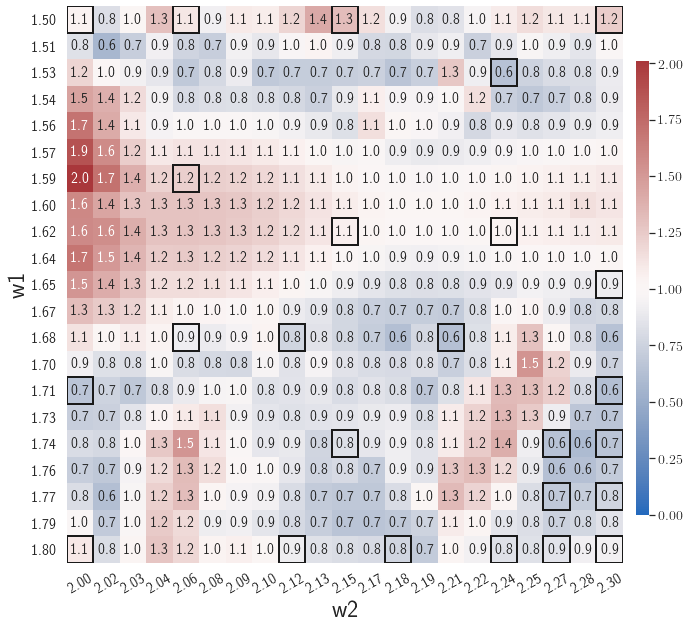

In [46]:
max_err_heatmap(max_err, sindy_idx, idx_list, idx_param, dtype='float')

idx: 0, param: [1.5 2. ]
idx: 420, param: [1.5 2.3]
idx: 20, param: [1.8 2. ]
idx: 440, param: [1.8 2.3]
idx: 226, param: [1.74 2.15]
idx: 96, param: [1.68 2.06]
idx: 210, param: [1.5  2.15]
idx: 344, param: [1.62 2.24]
idx: 218, param: [1.62 2.15]
idx: 306, param: [1.68 2.21]
idx: 84, param: [1.5  2.06]
idx: 356, param: [1.8  2.24]
idx: 272, param: [1.8  2.18]
idx: 188, param: [1.8  2.12]
idx: 14, param: [1.71 2.  ]
idx: 394, param: [1.74 2.27]
idx: 436, param: [1.74 2.3 ]
idx: 338, param: [1.53 2.24]
idx: 396, param: [1.77 2.27]
idx: 438, param: [1.77 2.3 ]
idx: 434, param: [1.71 2.3 ]
idx: 398, param: [1.8  2.27]
idx: 180, param: [1.68 2.12]
idx: 90, param: [1.59 2.06]
idx: 430, param: [1.65 2.3 ]


/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


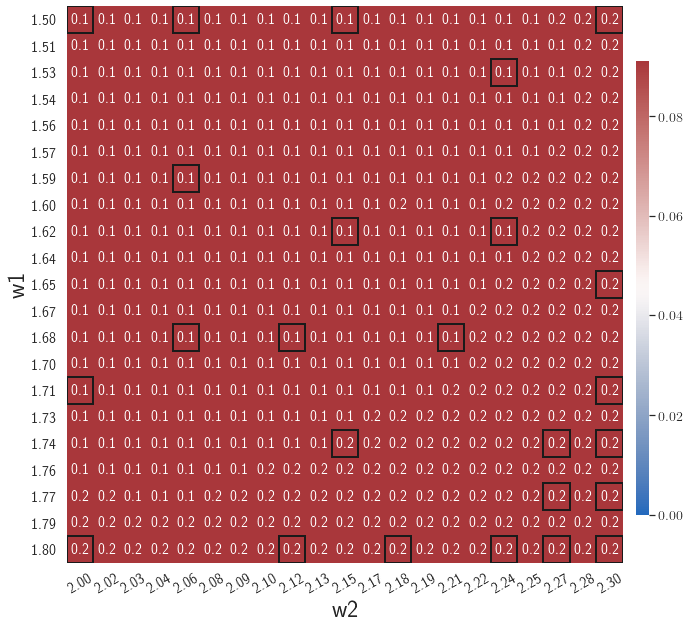

In [47]:
max_err_heatmap(res_norm, sindy_idx, idx_list, idx_param, label='Residual Norm', dtype='float', scale=10)